# Split Learning with SplitGuard detection 

The method is proposed in paper <SplitGuard: Detecting and Mitigating Training-Hijacking Attacks in Split Learning>.

## Initialization and model defination

In [1]:
import os

import matplotlib.pyplot as plt

import secretflow as sf

sf.shutdown()
sf.init(["alice", "bob"], address="local", num_cpus=6)
alice, bob = sf.PYU("alice"), sf.PYU("bob")
parties = [alice, bob]
import torch
from torch import nn as nn
from torch.nn import functional as F

from secretflow.ml.nn.utils import BaseModule


# The model structure is different from the original paper, thus there is defference in the hyper-parameters and results.
class ConvNetBase(BaseModule):
    """Small ConvNet basenet for MNIST."""

    def __init__(self):
        super(ConvNetBase, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5,),
            nn.ReLU(False),
            nn.MaxPool2d(2, 2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.ReLU(False),
            nn.MaxPool2d(2, 2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(16 * 4 * 4, 120)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

    def output_num(self):
        return 1


class ConvNetFuse(BaseModule):
    """Small fusenet for MNIST."""

    def __init__(self):
        super(ConvNetFuse, self).__init__()
        self.fc1 = nn.Linear(120 * 2, 120)
        self.fc1act = nn.ReLU(False)
        self.fc2 = nn.Linear(120, 84)
        self.fc2act = nn.ReLU(False)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.cat(x, dim=1)
        x = x.view(-1, 240)
        x = self.fc1(x)
        x = self.fc1act(x)
        x = self.fc2(x)
        x = self.fc2act(x)
        x = self.fc3(x)
        return x

2023-10-21 13:26:27,099	INFO worker.py:1538 -- Started a local Ray instance.


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


2023-10-21 13:26:31.013170: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-21 13:26:31.013447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-21 13:26:31.013462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Use label replace to compute the SG score(replace 7 batches out of 79 batches) 

In [2]:
import math
import os
import pickle
import random
import tempfile
from collections import namedtuple
from typing import Dict, List, Tuple, Union

import numpy as np
import torchvision
from torch import nn, optim
from torchmetrics import AUROC, Accuracy, Precision
from torchvision.datasets.mnist import read_image_file, read_label_file

from secretflow.data.ndarray import FedNdarray
from secretflow.device.device.pyu import PYU
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn.utils import TorchModel
from secretflow.utils.simulation.data.ndarray import create_ndarray
from slmodel_splitguard import SLModel_SG

_temp_dir = tempfile.mkdtemp()
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)
fake_batch = []


def load_fashionmnist(
    parts_train: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    parts_test: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    normalized_x: bool = True,
    categorical_y: bool = False,
    is_torch: bool = False,
    batch_size: int = 32,
    N: int = 20,
    P_F: float = 0.1,
    B_F: int = 32,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    x_train, y_train, x_test, y_test = [], [], [], []
    xpriv = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True)
    xpub = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True)
    train_imagefile = "train-images-idx3-ubyte"
    test_imagefile = "t10k-images-idx3-ubyte"
    train_labelfile = "train-labels-idx1-ubyte"
    test_labelfile = "t10k-labels-idx1-ubyte"
    raw_folder = "./data/FashionMNIST/raw/"
    train_data = read_image_file(os.path.join(raw_folder, train_imagefile))
    train_label = read_label_file(os.path.join(raw_folder, train_labelfile))
    test_data = read_image_file(os.path.join(raw_folder, test_imagefile))
    test_label = read_label_file(os.path.join(raw_folder, test_labelfile))

    x_train = train_data.numpy()
    y_train = [int(i) for i in train_label]
    y_train = np.array(y_train)
    x_test = test_data.numpy()
    y_test = [int(i) for i in test_label]
    y_test = np.array(y_test)

    # Set fake batches as paper.
    batch_num = len(y_train) // batch_size
    for i in range(batch_num):
        send_fakes = i > N and random.random() <= P_F
        if send_fakes and B_F > 0:
            index = random.sample(range(batch_size), B_F)
            index = [item + batch_size * i for item in index]
            for idx in index:
                y_train[idx] = (y_train[idx] + random.randint(1, 8)) % 10
            fake_batch.append(i)
    if normalized_x:
        x_train, x_test = x_train / 255, x_test / 255
    if categorical_y:
        from sklearn.preprocessing import OneHotEncoder

        encoder = OneHotEncoder(sparse=False)
        y_train = encoder.fit_transform(y_train.reshape(-1, 1))
        y_test = encoder.fit_transform(y_test.reshape(-1, 1))

    return (
        (
            create_ndarray(x_train, parts=parts_train, axis=0, is_torch=is_torch),
            create_ndarray(y_train, parts=parts_train, axis=0),
        ),
        (
            create_ndarray(x_test, parts=parts_test, axis=0, is_torch=is_torch),
            create_ndarray(y_test, parts=parts_test, axis=0),
        ),
    )


def create_dataset_builder(batch_size=32,):
    def dataset_builder(x):
        import pandas as pd
        import torch
        import torch.utils.data as torch_data

        x = [t.values if isinstance(t, pd.DataFrame) else t for t in x]
        x_copy = [torch.tensor(t.copy()) for t in x]
        data_set = torch_data.TensorDataset(*x_copy)
        dataloader = torch_data.DataLoader(dataset=data_set, batch_size=batch_size,)
        return dataloader

    return dataset_builder


def torch_model_with_fashionmnist(
    devices,
    base_model_dict,
    device_y,
    model_fuse,
    data_train,
    label_train,
    data_test,
    label_test,
    batch_size,
    N,
    alpha,
    beta,
    strategy="split_nn",
    backend="torch",
    **kwargs
):
    # kwargs parsing
    dp_strategy_dict = kwargs.get("dp_strategy_dict", None)
    compressor = kwargs.get("compressor", None)
    dataset_builder = kwargs.get("dataset_builder", None)

    base_local_steps = kwargs.get("base_local_steps", 1)
    fuse_local_steps = kwargs.get("fuse_local_steps", 1)
    bound_param = kwargs.get("bound_param", 0.0)

    loss_thres = kwargs.get("loss_thres", 0.01)
    split_steps = kwargs.get("split_steps", 1)
    max_fuse_local_steps = kwargs.get("max_fuse_local_steps", 10)

    # Define model class using modified class SLModel_SG
    sl_model = SLModel_SG(
        base_model_dict=base_model_dict,
        device_y=device_y,
        model_fuse=model_fuse,
        dp_strategy_dict=dp_strategy_dict,
        compressor=compressor,
        simulation=True,
        random_seed=1234,
        backend=backend,
        strategy=strategy,
        N=N,
        alpha=alpha,
        beta=beta,
        fake_batch=fake_batch,
        base_local_steps=base_local_steps,
        fuse_local_steps=fuse_local_steps,
        bound_param=bound_param,
        loss_thres=loss_thres,
        split_steps=split_steps,
        max_fuse_local_steps=max_fuse_local_steps,
    )
    # The fit() function is modified.
    history = sl_model.fit(
        data_train,
        label_train,
        validation_data=(data_test, label_test),
        epochs=5,
        batch_size=batch_size,
        shuffle=False,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )
    global_metric = sl_model.evaluate(
        data_test,
        label_test,
        batch_size=batch_size,
        random_seed=1234,
        dataset_builder=dataset_builder,
    )

    # test history
    print(global_metric)
    print(history)

    base_model_path = os.path.join(_temp_dir, "base_model")
    fuse_model_path = os.path.join(_temp_dir, "fuse_model")
    sl_model.save_model(
        base_model_path=base_model_path, fuse_model_path=fuse_model_path, is_test=True,
    )
    return sl_model.results, history["val_MulticlassAccuracy"][-1]

In [3]:
def test_torch_model(devices, batch_size, N, P_F, B_F, alpha, beta):
    alice = devices[0]
    bob = devices[1]
    num_samples_train = 60000
    num_samples_test = 10000
    (
        (fashionmnist_data_train, fashionmnist_label_train),
        (fashionmnist_data_test, fashionmnist_label_test),
    ) = load_fashionmnist(
        parts_train={alice: (0, num_samples_train), bob: (0, num_samples_train),},
        parts_test={alice: (0, num_samples_test), bob: (0, num_samples_test),},
        normalized_x=True,
        categorical_y=True,
        is_torch=True,
        batch_size=batch_size,
        N=N,
        P_F=P_F,
        B_F=B_F,
    )
    fashionmnist_data_train = fashionmnist_data_train.astype(np.float32)
    fashionmnist_label_train = fashionmnist_label_train.astype(np.float32)
    fashionmnist_data_test = fashionmnist_data_test.astype(np.float32)
    fashionmnist_label_test = fashionmnist_label_test.astype(np.float32)
    loss_fn = nn.CrossEntropyLoss
    optim_fn = optim_wrapper(optim.Adam, lr=5e-4)
    base_model = TorchModel(
        model_fn=ConvNetBase,
        loss_fn=loss_fn,
        optim_fn=optim_fn,
        metrics=[
            metric_wrapper(
                Accuracy, task="multiclass", num_classes=10, average="micro"
            ),
            metric_wrapper(
                Precision, task="multiclass", num_classes=10, average="micro"
            ),
            metric_wrapper(AUROC, task="multiclass", num_classes=10),
        ],
    )

    fuse_model = TorchModel(
        model_fn=ConvNetFuse,
        loss_fn=loss_fn,
        optim_fn=optim_fn,
        metrics=[
            metric_wrapper(
                Accuracy, task="multiclass", num_classes=10, average="micro"
            ),
            metric_wrapper(
                Precision, task="multiclass", num_classes=10, average="micro"
            ),
            metric_wrapper(AUROC, task="multiclass", num_classes=10),
        ],
    )
    base_model_dict = {
        alice: base_model,
        bob: base_model,
    }

    # test dataset builder
    print("test Dataset builder")
    dataset_builder_dict = {
        alice: create_dataset_builder(batch_size=batch_size,),
        bob: create_dataset_builder(batch_size=batch_size,),
    }
    result, acc = torch_model_with_fashionmnist(
        devices=devices,
        base_model_dict=base_model_dict,
        device_y=bob,
        model_fuse=fuse_model,
        data_train=fashionmnist_data_train,
        label_train=fashionmnist_label_train,
        data_test=fashionmnist_data_test,
        label_test=fashionmnist_label_test,
        N=N,
        alpha=alpha,
        beta=beta,
        batch_size=batch_size,
        strategy="split_nn",
        backend="torch",
        dataset_builder=dataset_builder_dict,
    )
    return result, acc


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1ad9b0a0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1ad9b340>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1ad9ba60>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1ad9b910>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1ad9bb50>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1ad9bb80>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(0.6050156, dtype=float32), 'MulticlassAccuracy': tensor(0.7456), 'MulticlassPrecision': tensor(0.7456), 'MulticlassAUROC': tensor(0.9607)}
{'train_loss': [array(0.76572424, dtype=float32), array(0.73758775, dtype=float32), array(0.7485367, dtype=float32), array(0.7271271, dtype=float32), array(0.67813045, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.6146), tensor(0.6791), tensor(0.6872), tensor(0.6907), tensor(0.6927)], 'train_MulticlassPrecision': [tensor(0.6146), tensor(0.6791), tensor(0.6872), tensor(0.6907), tensor(0.6927)], 'train_MulticlassAUROC': [tensor(0.9037), tensor(0.9193), tensor(0.9213), tensor(0.9214), tensor(0.9223)], 'val_val_loss': [array(0.4624341, dtype=float32), array(0.43484733, dtype=float32), array(0.6105604, dtype=float32), array(0.49531037, dtype=float32), array(0.6050156, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.7263), tensor(0.7442), tensor(0.7360), tensor(0.7327), tensor(0.7456)], 'val_MulticlassPrecision': [tensor(0

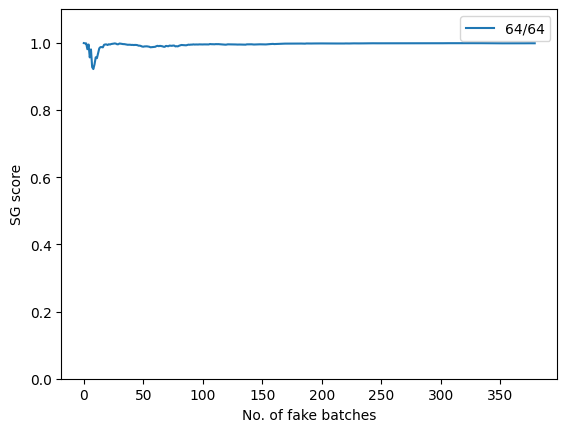

In [4]:

batch_size = 64
N = 20
P_F = 0.1
B_F = 64
alpha = 5
beta = 2
fake_batch = []
scores0, acc0 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)

plt.plot(scores0, label="64/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.


test Dataset builder


INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1a86a760>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1a894d60>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1a894220>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1a8944c0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1a894d90>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1a820070>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1a8203d0>, PYURuntime(bob): <s

{'val_loss': array(0.3073972, dtype=float32), 'MulticlassAccuracy': tensor(0.7958), 'MulticlassPrecision': tensor(0.7958), 'MulticlassAUROC': tensor(0.9732)}
{'train_loss': [array(0.85586226, dtype=float32), array(0.7191232, dtype=float32), array(0.74662197, dtype=float32), array(0.66809475, dtype=float32), array(0.6882183, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.6486), tensor(0.7312), tensor(0.7494), tensor(0.7584), tensor(0.7635)], 'train_MulticlassPrecision': [tensor(0.6486), tensor(0.7312), tensor(0.7494), tensor(0.7584), tensor(0.7635)], 'train_MulticlassAUROC': [tensor(0.9271), tensor(0.9442), tensor(0.9479), tensor(0.9500), tensor(0.9508)], 'val_val_loss': [array(0.5452285, dtype=float32), array(0.64034545, dtype=float32), array(0.55349416, dtype=float32), array(0.4808926, dtype=float32), array(0.3073972, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.7250), tensor(0.7470), tensor(0.7603), tensor(0.7603), tensor(0.7958)], 'val_MulticlassPrecision': [tensor(0

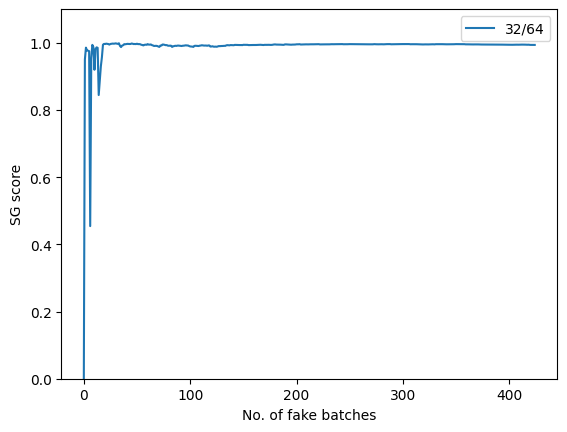

In [5]:
B_F = 32
fake_batch = []
scores1, acc1 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)
plt.plot(scores1, label="32/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4b9047b730>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4b9047bb20>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4b9047bf70>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4b90453490>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4b90451d30>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4b90451f40>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(0.24289218, dtype=float32), 'MulticlassAccuracy': tensor(0.8256), 'MulticlassPrecision': tensor(0.8256), 'MulticlassAUROC': tensor(0.9794)}
{'train_loss': [array(0.7220424, dtype=float32), array(0.64458716, dtype=float32), array(0.5715898, dtype=float32), array(0.512679, dtype=float32), array(0.50101006, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.6673), tensor(0.7659), tensor(0.7911), tensor(0.8016), tensor(0.8074)], 'train_MulticlassPrecision': [tensor(0.6673), tensor(0.7659), tensor(0.7911), tensor(0.8016), tensor(0.8074)], 'train_MulticlassAUROC': [tensor(0.9381), tensor(0.9587), tensor(0.9634), tensor(0.9657), tensor(0.9673)], 'val_val_loss': [array(0.5146074, dtype=float32), array(0.5580825, dtype=float32), array(0.3761208, dtype=float32), array(0.29325312, dtype=float32), array(0.24289218, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.7235), tensor(0.7681), tensor(0.8148), tensor(0.8219), tensor(0.8256)], 'val_MulticlassPrecision': [tensor(0.

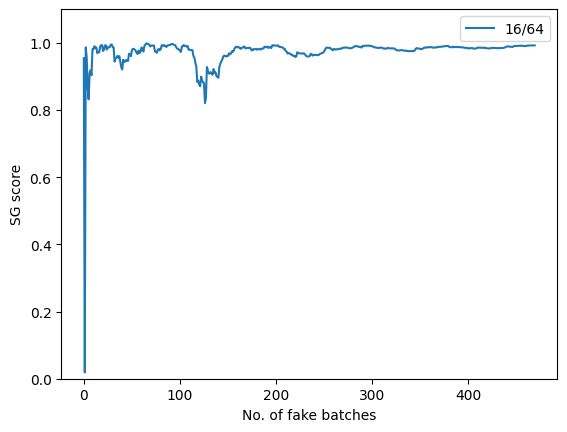

In [6]:
B_F = 16
fake_batch = []
scores2, acc2 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)
plt.plot(scores2, label="16/64")
plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

In [7]:
B_F = 0
fake_batch = []
scores3, acc3 = test_torch_model(parties, batch_size, N, P_F, B_F, alpha, beta)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party alice.


test Dataset builder


INFO:root:Create proxy actor <class 'secretflow.ml.nn.sl.backend.torch.strategy.split_nn.PYUSLTorchModel'> with party bob.
INFO:root:SL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4c1a859bb0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4b901541f0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4b9015feb0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4b9015ff10>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 64, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f4b9046a5b0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f4b9047b0a0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNd

{'val_loss': array(0.22058114, dtype=float32), 'MulticlassAccuracy': tensor(0.8663), 'MulticlassPrecision': tensor(0.8663), 'MulticlassAUROC': tensor(0.9886)}
{'train_loss': [array(0.58906555, dtype=float32), array(0.5149338, dtype=float32), array(0.40089965, dtype=float32), array(0.34298262, dtype=float32), array(0.31390753, dtype=float32)], 'train_MulticlassAccuracy': [tensor(0.6964), tensor(0.8144), tensor(0.8495), tensor(0.8667), tensor(0.8765)], 'train_MulticlassPrecision': [tensor(0.6964), tensor(0.8144), tensor(0.8495), tensor(0.8667), tensor(0.8765)], 'train_MulticlassAUROC': [tensor(0.9554), tensor(0.9782), tensor(0.9846), tensor(0.9882), tensor(0.9901)], 'val_val_loss': [array(0.43815368, dtype=float32), array(0.42707458, dtype=float32), array(0.36240393, dtype=float32), array(0.28657335, dtype=float32), array(0.22058114, dtype=float32)], 'val_MulticlassAccuracy': [tensor(0.7739), tensor(0.8235), tensor(0.8445), tensor(0.8605), tensor(0.8663)], 'val_MulticlassPrecision': [ten

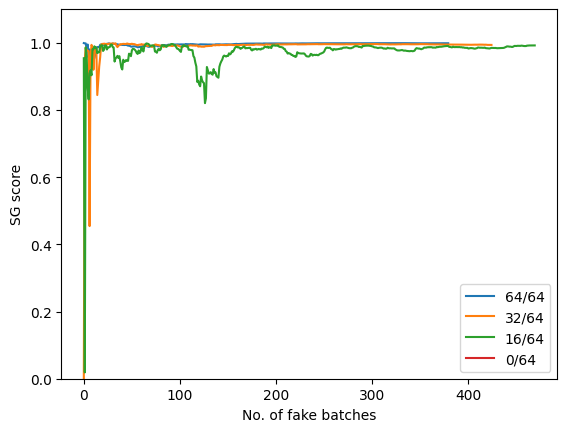

In [8]:
plt.plot(scores0, label="64/64")
plt.plot(scores1, label="32/64")
plt.plot(scores2, label="16/64")
plt.plot(scores3, label="0/64")

plt.ylim(0, 1.1)
plt.xlabel("No. of fake batches")# xlabel means the index of fake batch in the total training.
plt.ylabel("SG score")
plt.legend()
plt.savefig("sf-sgscore.png")
plt.show()

In [9]:
print(
    "Test classification accuracy values for the MNIST dataset for different B_F values with SplitGuard, with P_F=0.1"
)
print("BF=64, ACC=", acc0)
print("BF=32, ACC=", acc1)
print("BF=16, ACC=", acc2)
print("BF=0, ACC=", acc3)

Test classification accuracy values for the MNIST dataset for different B_F values with SplitGuard, with P_F=0.1
BF=64, ACC= tensor(0.7456)
BF=32, ACC= tensor(0.7958)
BF=16, ACC= tensor(0.8256)
BF=0, ACC= tensor(0.8663)
